In [1]:
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt

## Thrust Data

In [2]:
thrustFromFile = np.genfromtxt('./AeroTech_L1520T.csv',delimiter=',')

In [3]:
thrust = np.insert(thrustFromFile,0,[0,0],axis=0)

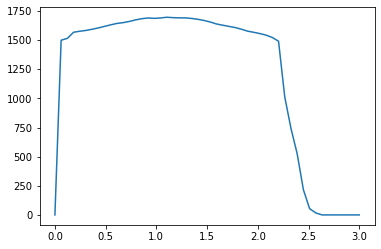

In [4]:
plt.plot(np.linspace(0,3),np.interp(np.linspace(0,3),thrust[:,0],thrust[:,1]));

In [5]:
#returns thrust force given a certain time in Newtons (N)
def thrustFunc(t):
    return 1.01*np.interp(t,thrust[:,0],thrust[:,1])

#returns an approximation for the density of air at a given altitutde
def rho(altitude):
    rho0 = 1.225 #kg/m^3
    Hn = 10.4*10**3 #meters
    return rho0*np.exp(-altitude/Hn)

## Simulation settings

In [6]:
dt=0.0001
tInitial = 0
tFinal = 60
time = np.arange(tInitial,tFinal,dt)

In [7]:
mass = 20 #kg
gravityForce = np.array([0,0,-9.81])*mass
Area = 0.0232
parachuteDragCoefficient = 10

## VLT

In [8]:
initialVel = 175
targetAlt = 1100
def velocityProfile(alt):
    return initialVel/np.sqrt(targetAlt)*np.sqrt(targetAlt-alt)

altitudes = np.linspace(0,targetAlt,100)

velocityLookupTableBase = np.array([altitudes,velocityProfile(altitudes)])
velocityLookupTable = np.transpose(np.genfromtxt('./DragVLT.csv',delimiter=','))

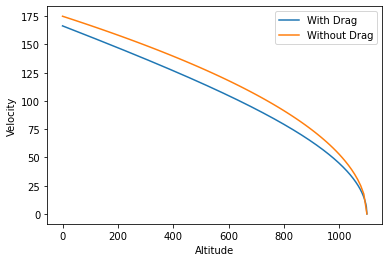

In [9]:
plt.plot(velocityLookupTable[0],velocityLookupTable[1]);
plt.plot(velocityLookupTableBase[0],velocityLookupTableBase[1]);
plt.legend(['With Drag','Without Drag']);
plt.xlabel('Altitude');
plt.ylabel('Velocity');

## Wind Settings

In [10]:
#function that kinda simulates random winds on the way up
def windFunc(time):
    return 1*(np.sin(time/2)+np.cos(time/20))

windxStdDev = .5
windyStdDev = .5
windzStdDev = .5
#ratio of z wind to xy wind
windzRatio = .5

## Controller Settings

In [137]:
#TODO: change over time
maxError = 40
controlFrequency= 8 #Hz
controldt = 1/controlFrequency
controlTicks = int(controldt//dt) #in number of ticks (if dt = 0.001, then this represents ms)
airbrakesMaxDrag = .2

def errorDecayFunc(alt):
    errorDecayTable = np.array([[targetAlt/2,7/8*targetAlt, 2*targetAlt],
                                [    6      ,    1.5,           0]])
    #find the index of the first altitude entry which is greater than the current altitude
    index = np.argmax((errorDecayTable[0]-alt)>0)
    return errorDecayTable[1,index]

def getMaxError(alt):
    maxErrorTable = np.array([[targetAlt/2,7/8*targetAlt, 2*targetAlt],
                                [    30      ,    10,           5]])
    #find the index of the first altitude entry which is greater than the current altitude
    index = np.argmax((maxErrorTable[0]-alt)>0)
    return maxErrorTable[1,index]

def calculateError(position,velocity):
    altitude = position[2]
    velocityError = velocity[2] - np.interp(altitude, velocityLookupTable[0],velocityLookupTable[1])
    if(velocityError < 0):
        velocityError = 0
    return velocityError

## Kalman Filter settings

In [138]:
#kalman step size
sampleFrequency = 100 #Hz
kdt = 1/sampleFrequency
#for loop
kalmanTicks = int(kdt//dt)

#state Vector
#X = [[x],[y],[z],[vx],[vy],[vz],[ax],[ay],[az]]

#state transition matrix
Fkalman = np.array([[1,0,0,kdt,  0,  0,1/2*kdt**2,         0,         0],
                    [0,1,0,  0,kdt,  0,         0,1/2*kdt**2,         0],
                    [0,0,1,  0,  0,kdt,         0,         0,1/2*kdt**2],
                    [0,0,0,  1,  0,  0,       kdt,         0,         0],
                    [0,0,0,  0,  1,  0,         0,       kdt,         0],
                    [0,0,0,  0,  0,  1,         0,         0,       kdt],
                    [0,0,0,  0,  0,  0,         1,         0,         0],
                    [0,0,0,  0,  0,  0,         0,         1,         0],
                    [0,0,0,  0,  0,  0,         0,         0,         1]])

#Input translation matrix
#take input accelerations from rocket thrust and turn that into state matrix adjustment
Gkalman = np.array([[1/2*kdt**2,0,0],
                    [0,1/2*kdt**2,0],
                    [0,0,1/2*kdt**2],
                    [kdt,0,0],
                    [0,kdt,0],
                    [0,0,kdt],
                    [1,0,0],
                    [0,1,0],
                    [0,0,1]])

#observation model
#converts state vector to equivalent oberservations 
#we get the altitude from the altimeter and the acceleration data from IMU
Hkalman = np.array([[0,0,1,0,0,0,0,0,0],
                    [0,0,0,0,0,0,1,0,0],
                    [0,0,0,0,0,0,0,1,0],
                    [0,0,0,0,0,0,0,0,1]])

HkalmanDualIMU = np.array([[0,0,1,0,0,0,0,0,0],
                           [0,0,0,0,0,0,1,0,0],
                           [0,0,0,0,0,0,0,1,0],
                           [0,0,0,0,0,0,0,0,1],
                           [0,0,0,0,0,0,1,0,0],
                           [0,0,0,0,0,0,0,1,0],
                           [0,0,0,0,0,0,0,0,1]])

#estimate covariance
#should be zero to start because we know exactly where the rocket starts
#however, setting it to this makes the kalman algorithm slow to adjust to the rapid start in motion
Pkalman = np.zeros((9,9))

#process noise
processVar=(.5)**2
Qkalman = np.matmul(Gkalman,np.transpose(Gkalman))*processVar

#measurement covariance
altimeterVar = (10)**2
accelXVar = (1)**2
accelYVar = (1)**2
accelZVar = (1)**2
#high gain accel variances
accelXVarHG = (2)**2
accelYVarHG = (2)**2
accelZVarHG = (2)**2

#measurement covariance matrix
Rkalman = np.array([[altimeterVar,0,0,0],
                    [0,           accelXVar,0,0],
                    [0,           0,accelYVar,0],
                    [0,           0,0,accelZVar]])

#Rkalman for dual IMU
RkalmanDualIMU = np.array([[altimeterVar        ,0,0,0,0,0,0],
                    [0,           accelXVar,0,0,0,0,0],
                    [0,           0,accelYVar,0,0,0,0],
                    [0,           0,0,accelZVar,0,0,0],
                    [0,           0,0,0,accelXVarHG,0,0],
                    [0,           0,0,0,0,accelYVarHG,0],
                    [0,           0,0,0,0,0,accelZVarHG]])

#measurement drift settings
accelXdrift = .001*dt #m/s
accelYdrift = .001*dt #m/s
accelZdrift = .001*dt #m/s

## Integration Loop

In [139]:
time = np.arange(tInitial,tFinal,dt)
positions = np.zeros((len(time),3)); # x,y,z
velocities = np.zeros((len(time),3)); # vx,vy,vz
accelerations = np.zeros((len(time),3)); #ax,ay,az
dragCoefficient  = np.full((len(time)),.4);
#errorArray = np.full((len(time)),0);
stateVectors = np.zeros((len(time),9))
#measurements = np.zeros((len(time),7))
Pkalman = np.eye(9)
innovation = 0
innovationCov = 0

integralError = 0;
#used to turn off controller after apogee
runControl = True;

#used to truncate data
finalTick = 0

#settings for using dual IMU config
#performance is not significantly different - probably better to run kalman filter twice as fast 
dualIMU = False
if dualIMU == True:
    Hkalman = HkalmanDualIMU
    Rkalman = RkalmanDualIMU
    measurements = np.zeros((len(time),7))
else:
    measurements = np.zeros((len(time),4))

for i in range(len(time)-1):
    #determine which way the rocket is pointing
    direction = velocities[i]/(np.linalg.norm(velocities[i])+10**-9)
    
    #if on rail, launch angle is set
    if(positions[i,2]<1):
        direction = np.array([0,np.sin(0.0873),np.cos(0.0873)])
        
    #wind force - random gusts of wind pushing the rocket on the way up
    #wind mostly blows side to side and not up and down (I think?)
    windforce = windFunc(time[i])*np.array([rand.normal(loc=1,scale=windxStdDev),rand.normal(loc=1,scale=windyStdDev),rand.normal(loc=windzRatio,scale=windzStdDev)])
    
    sumForces = gravityForce + (thrustFunc(time[i]) - 1/2*Area*rho(positions[i,2])*np.linalg.norm(velocities[i])**2*dragCoefficient[i])*direction+windforce
    
    #ends simulation when rocket hits ground
    if (positions[i,2]<=0) and (time[i]>1):
        finalTick = i
        break
    
    #integration
    accelerations[i] = sumForces/mass
    velocities[i+1] = accelerations[i]*dt + velocities[i]
    positions[i+1] = velocities[i]*dt + positions[i]
        
    #Kalman filter attempt
    if((i%kalmanTicks==0) and (i>0)):
        #takes the current altitude and x,y,z accelerations and adds defined noise to those values
        #these values become the measurement that is fed into the kalman filter
        #the first step of the kalman filter is to predict what the next state should be based on the previous
        #step and the state transition matrix (essentially just forward integration)
        #it then converts this into the measurement space with Hkalman and comapres this with actual measured values
        #this difference is called the innovation
        #the kalman filter then corrects its guess at the next state by calculating the optimal gain Kkalman
        #Kkalman is determined by comparing the estimate covariance (how confident it is in the current estimate) and 
        #the innovation covariance (how confident it is in the measurement)
        
        #take measurement
        if dualIMU == True:
            measurements[i:i+kalmanTicks] = [positions[i,2]+rand.normal(0,np.sqrt(altimeterVar)),
                                         accelerations[i,0]+rand.normal(accelXdrift,np.sqrt(accelXVar)),
                                         accelerations[i,1]+rand.normal(accelYdrift,np.sqrt(accelYVar)),
                                         accelerations[i,2]+rand.normal(accelZdrift,np.sqrt(accelZVar)),
                                         accelerations[i,0]+rand.normal(accelXdrift,np.sqrt(accelXVarHG)),
                                         accelerations[i,1]+rand.normal(accelYdrift,np.sqrt(accelYVarHG)),
                                         accelerations[i,2]+rand.normal(accelZdrift,np.sqrt(accelZVarHG))]
        else:
            measurements[i:i+kalmanTicks] = [positions[i,2]+rand.normal(0,np.sqrt(altimeterVar)),
                                         accelerations[i,0]+rand.normal(accelXdrift,np.sqrt(accelXVar)),
                                         accelerations[i,1]+rand.normal(accelYdrift,np.sqrt(accelYVar)),
                                         accelerations[i,2]+rand.normal(accelZdrift,np.sqrt(accelZVar))]
        
        ###Predict Step        
        stateVectors[i:i+kalmanTicks] = np.matmul(Fkalman, stateVectors[i-kalmanTicks])
        #Potentially add step that increases Qkalman during motor burn, then decreases it
        Pkalman = np.matmul(Fkalman,np.matmul(Pkalman,np.transpose(Fkalman))) + Qkalman
        
        ###Update Step
        innovation = measurements[i] - np.matmul(Hkalman,stateVectors[i])
        
        innovationCov = np.matmul(Hkalman,np.matmul(Pkalman,np.transpose(Hkalman)))+Rkalman
        
        #optimal Kalman Gain
        Kkalman = np.matmul(Pkalman,np.matmul(np.transpose(Hkalman),np.linalg.inv(innovationCov)))
        #print(np.linalg.norm(Kkalman))
        
        #update state estimate
        stateVectors[i:i+kalmanTicks] = stateVectors[i] + np.matmul(Kkalman,innovation)
        #update estimate covariance
        Pkalman = np.matmul((np.eye(9)-np.matmul(Kkalman,Hkalman)),Pkalman)
        
    #deploy parachute when rocket hits apogee
    if ((stateVectors[i,5]<=0) and (time[i]>1)) and runControl == True:
        runControl = False
        dragCoefficient[i:] = parachuteDragCoefficient
        
    #control algorithim, evaluate periodically (250 ticks or 250 m/s)
    if(i%controlTicks==0) and runControl:
        #control algorithm outline
        # - determine how off the rocket velocity is from VLT given altitude
        #     - clip this value so that it less than the max allowable
        # - add the current error to the integral error term
        #     - subtract error decay given altitude
        #     - integral error penalizes being wrong for long period of time
        #     - have decay so that it doesn't always blow up to inf + allows me to make controller more strict over time
        # - control parameter is determined by summing current error and integral error and dividing by max error
        #     - airbrakes are then deployed such that that percentage of the drag coefficient is deployed
        #     - TODO: create transfer function from control parameter to deployment percentage
        #         - assume to be linear initially
        
        maxError = getMaxError(stateVectors[i,2])
        #calculate how off the velocity is from desired
        error = calculateError(stateVectors[i,0:3],stateVectors[i,3:6])
        
        #clip error so that it is at most maxError
        if error>maxError:
            error = maxError
        
        #add this error to integralError
        #This will take account of continually wrong velocities and give it a boost
        #errorDecay helps this term not just grow over time
        #effectively means it will help velocity get within errorDecay of desiredVelocity
        integralError += error - errorDecayFunc(positions[i,2])
        
        #if within a close value of the target vel, set the integral error to zero so that we don't overshoot
        if error<.1:
            integralError = 0
        
        if integralError < 0:
            integralError = 0
        
        #calculate how much control we want to exert as a function of the maximum
        control = (error+integralError)/maxError
        
        #if control is greater than 1, bring it down
        if control >1:
            control = 1
        
        #adjust the drag coefficient for the next section of the simulation
        dragCoefficient[i:i+controlTicks] = dragCoefficient[i:i+controlTicks]+control*airbrakesMaxDrag
        
time = time[:finalTick]
measurements = measurements[:finalTick]
positions = positions[:finalTick]
velocities = velocities[:finalTick]
accelerations = accelerations[:finalTick]
stateVectors = stateVectors[:finalTick]
dragCoefficient = dragCoefficient[:finalTick]

## Plots

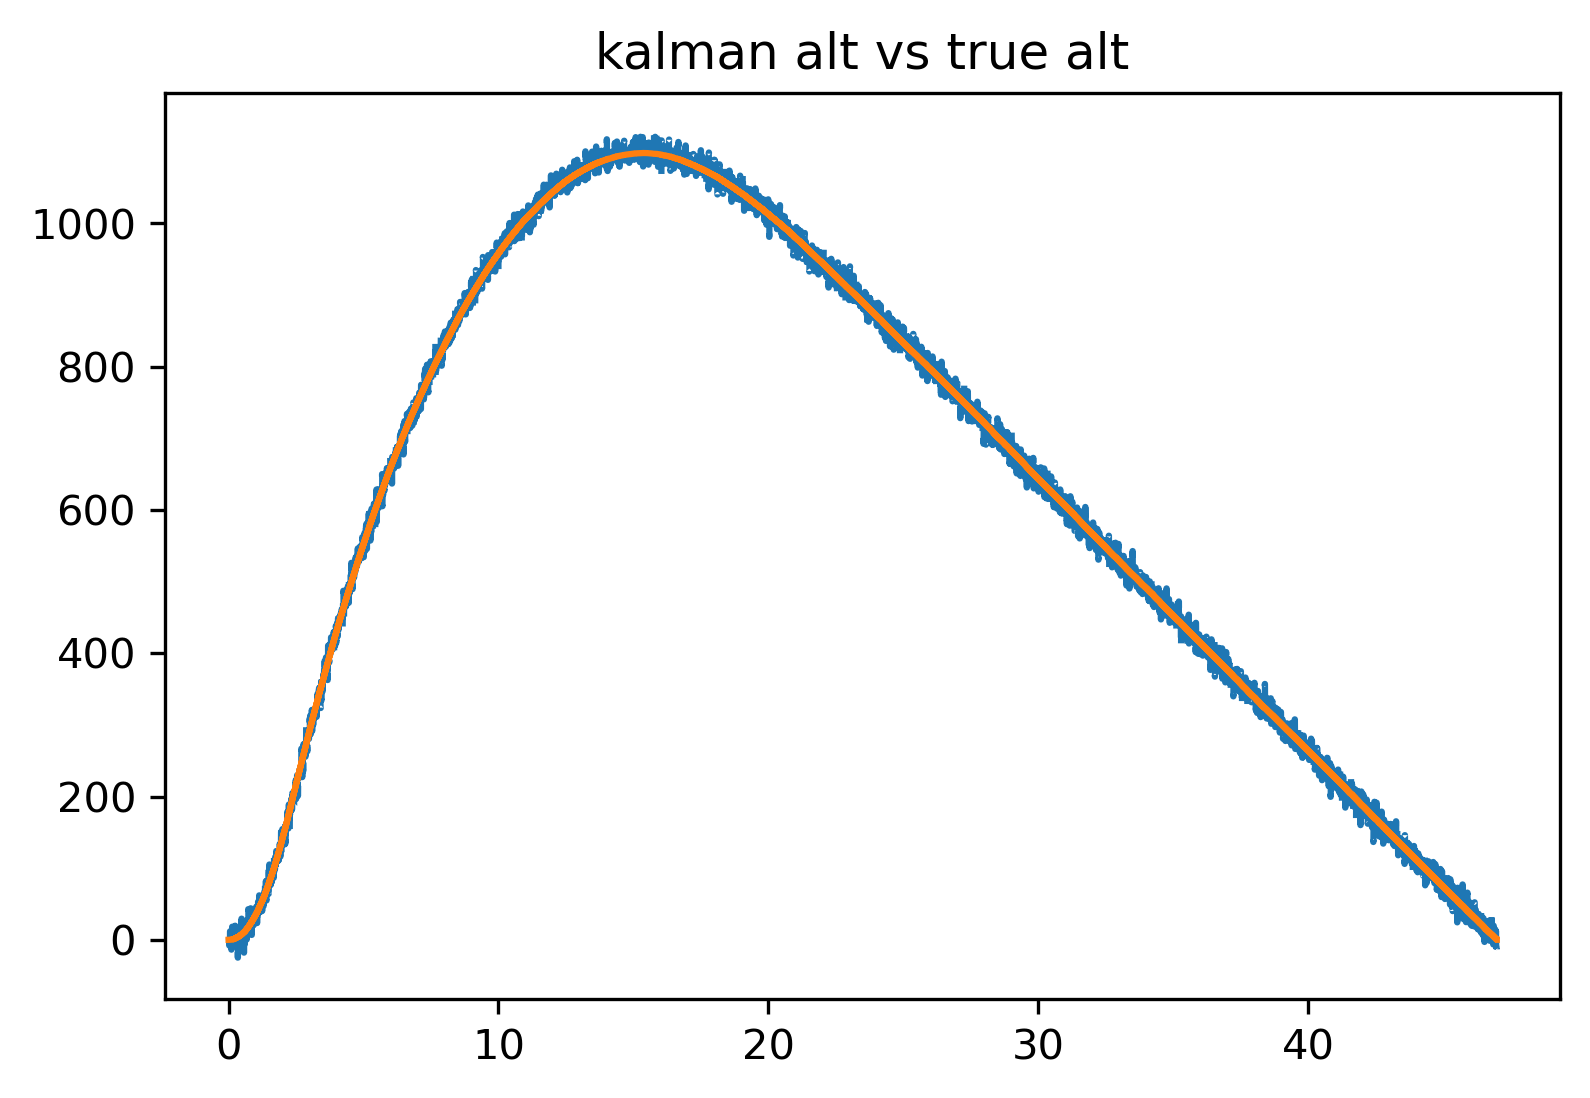

In [140]:
plt.figure(dpi=300)
plt.plot(time,measurements[:,0],'--');
plt.plot(time,stateVectors[:,2])
plt.title('kalman alt vs true alt');

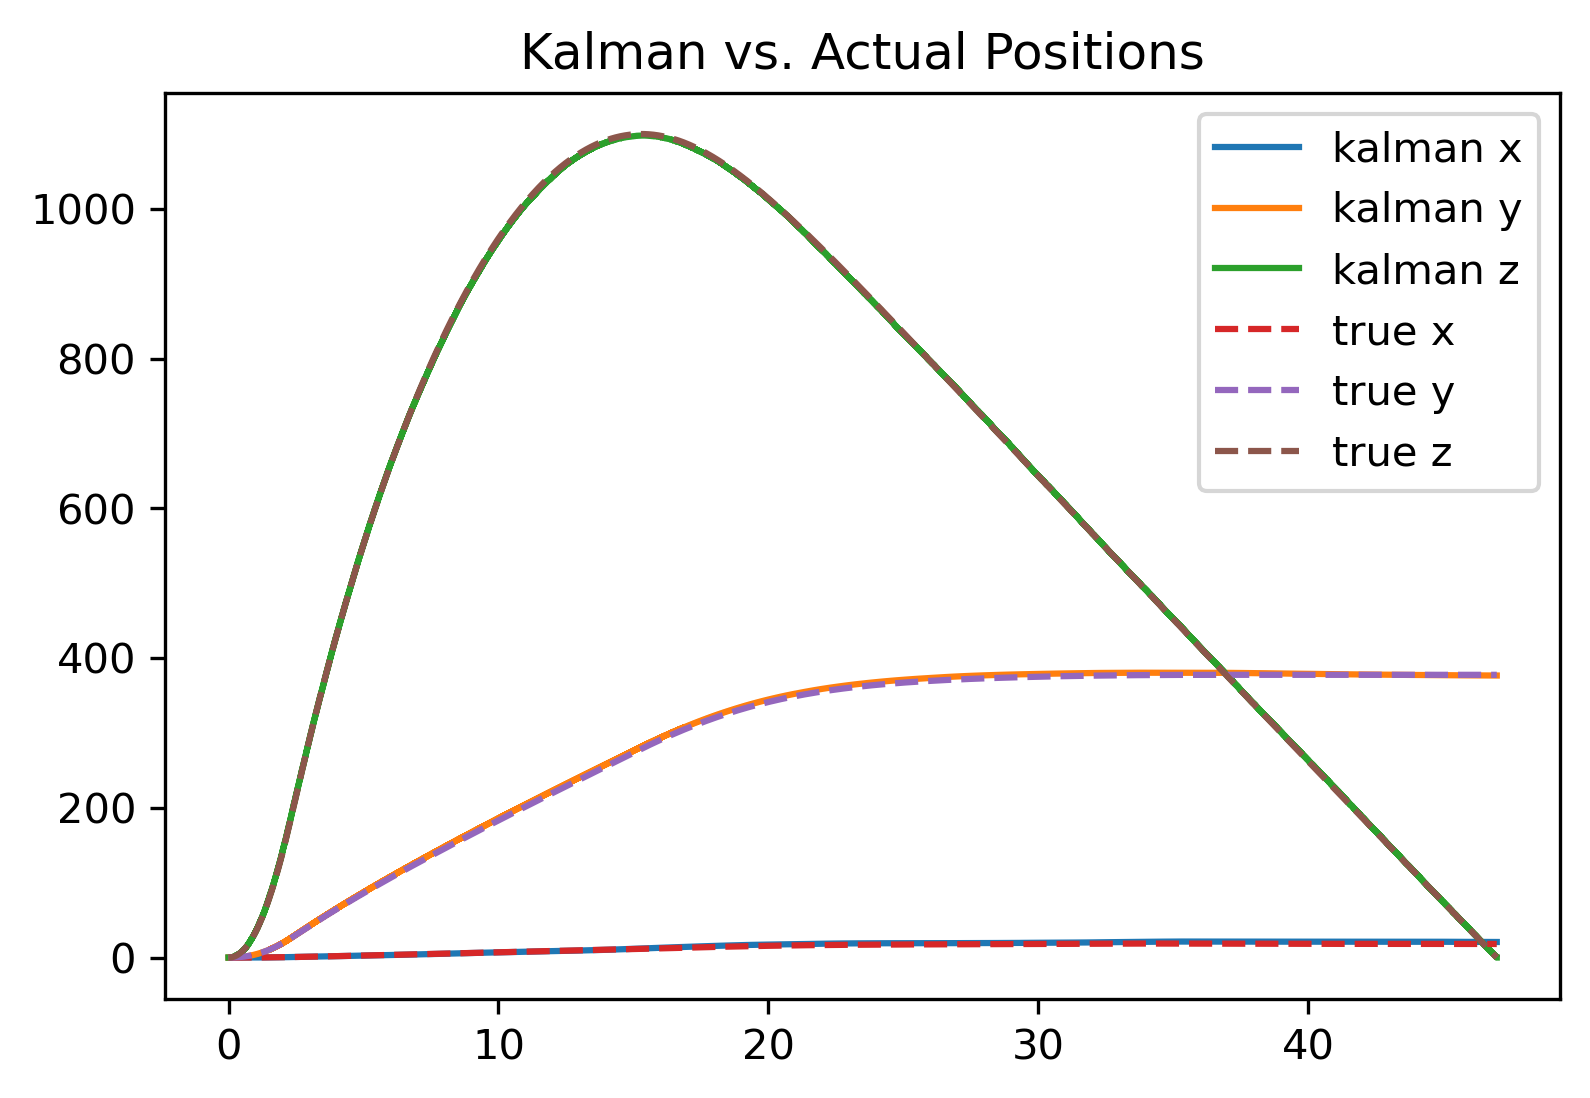

In [141]:
plt.figure(dpi=300)
plt.plot(time,stateVectors[:,0:3]);
plt.plot(time,positions,'--');
plt.legend(['kalman x','kalman y','kalman z','true x','true y','true z'])
plt.title('Kalman vs. Actual Positions');

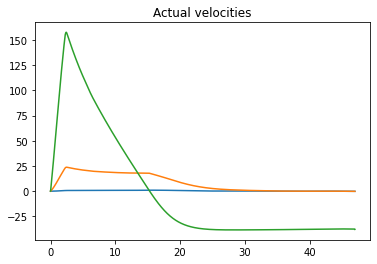

In [142]:
plt.plot(time,velocities);
plt.title('Actual velocities');

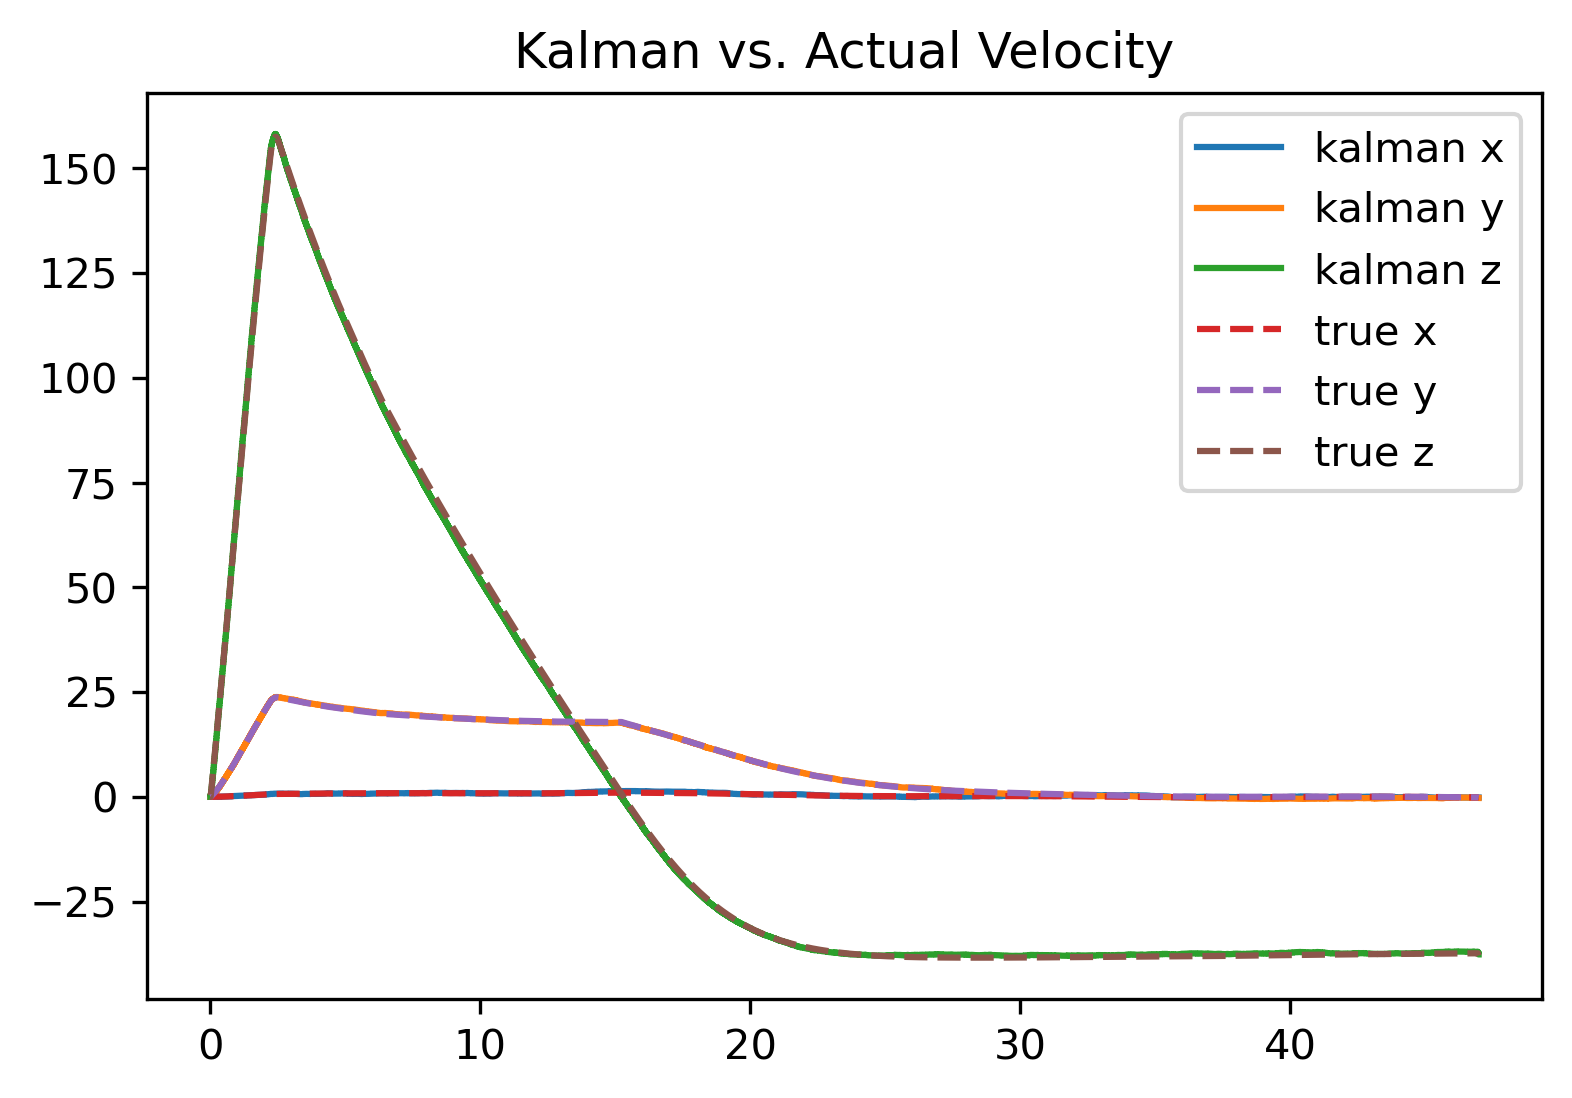

In [143]:
plt.figure(dpi=300)
plt.plot(time,stateVectors[:,3:6]);
plt.plot(time,velocities,'--');
plt.legend(['kalman x','kalman y','kalman z','true x','true y','true z'])
plt.title('Kalman vs. Actual Velocity');

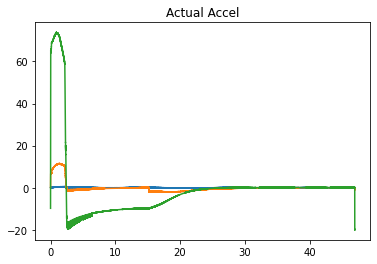

In [144]:
plt.plot(time,accelerations);
plt.title('Actual Accel');

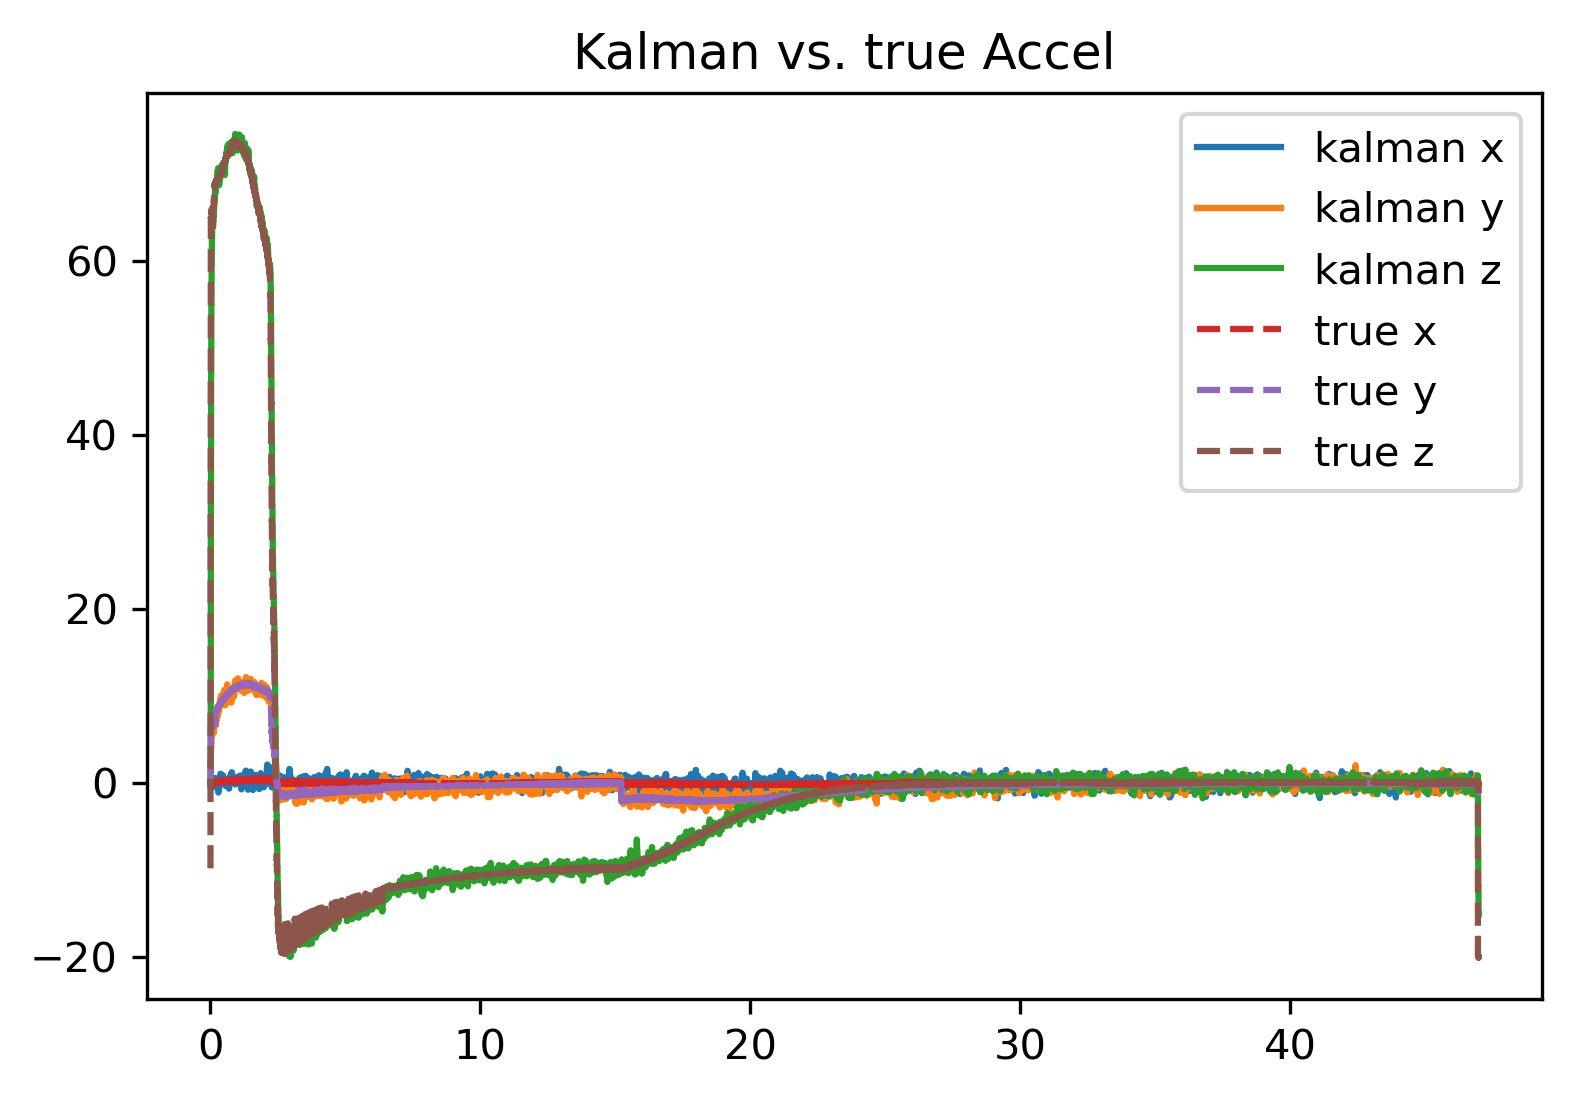

In [145]:
plt.figure(dpi=300)
plt.plot(time,stateVectors[:,6:9]);
plt.plot(time, accelerations,'--');
plt.legend(['kalman x','kalman y','kalman z','true x','true y','true z'])
plt.title('Kalman vs. true Accel');
#plt.xlim([0,10]);

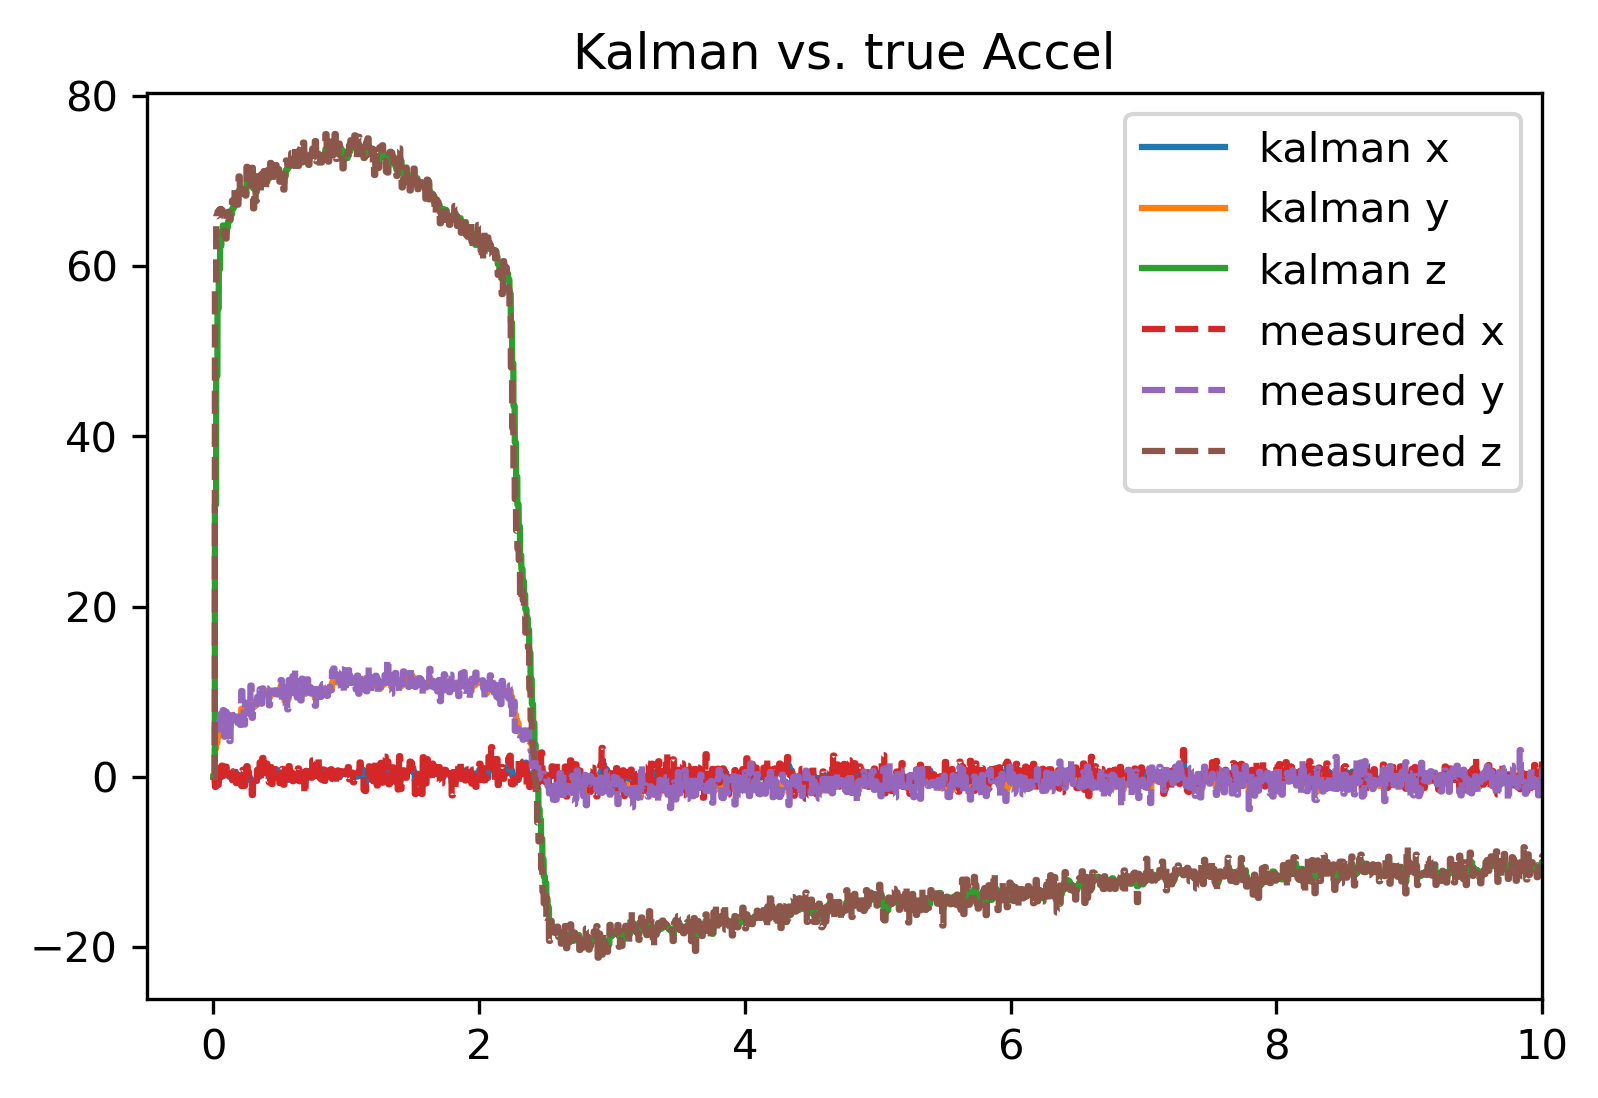

In [146]:
plt.figure(dpi=300)
plt.plot(time,stateVectors[:,6:9]);
plt.plot(time, measurements[:,1:4],'--');
plt.legend(['kalman x','kalman y','kalman z','measured x','measured y','measured z'])
plt.title('Kalman vs. true Accel');
plt.xlim([-.5,10]);

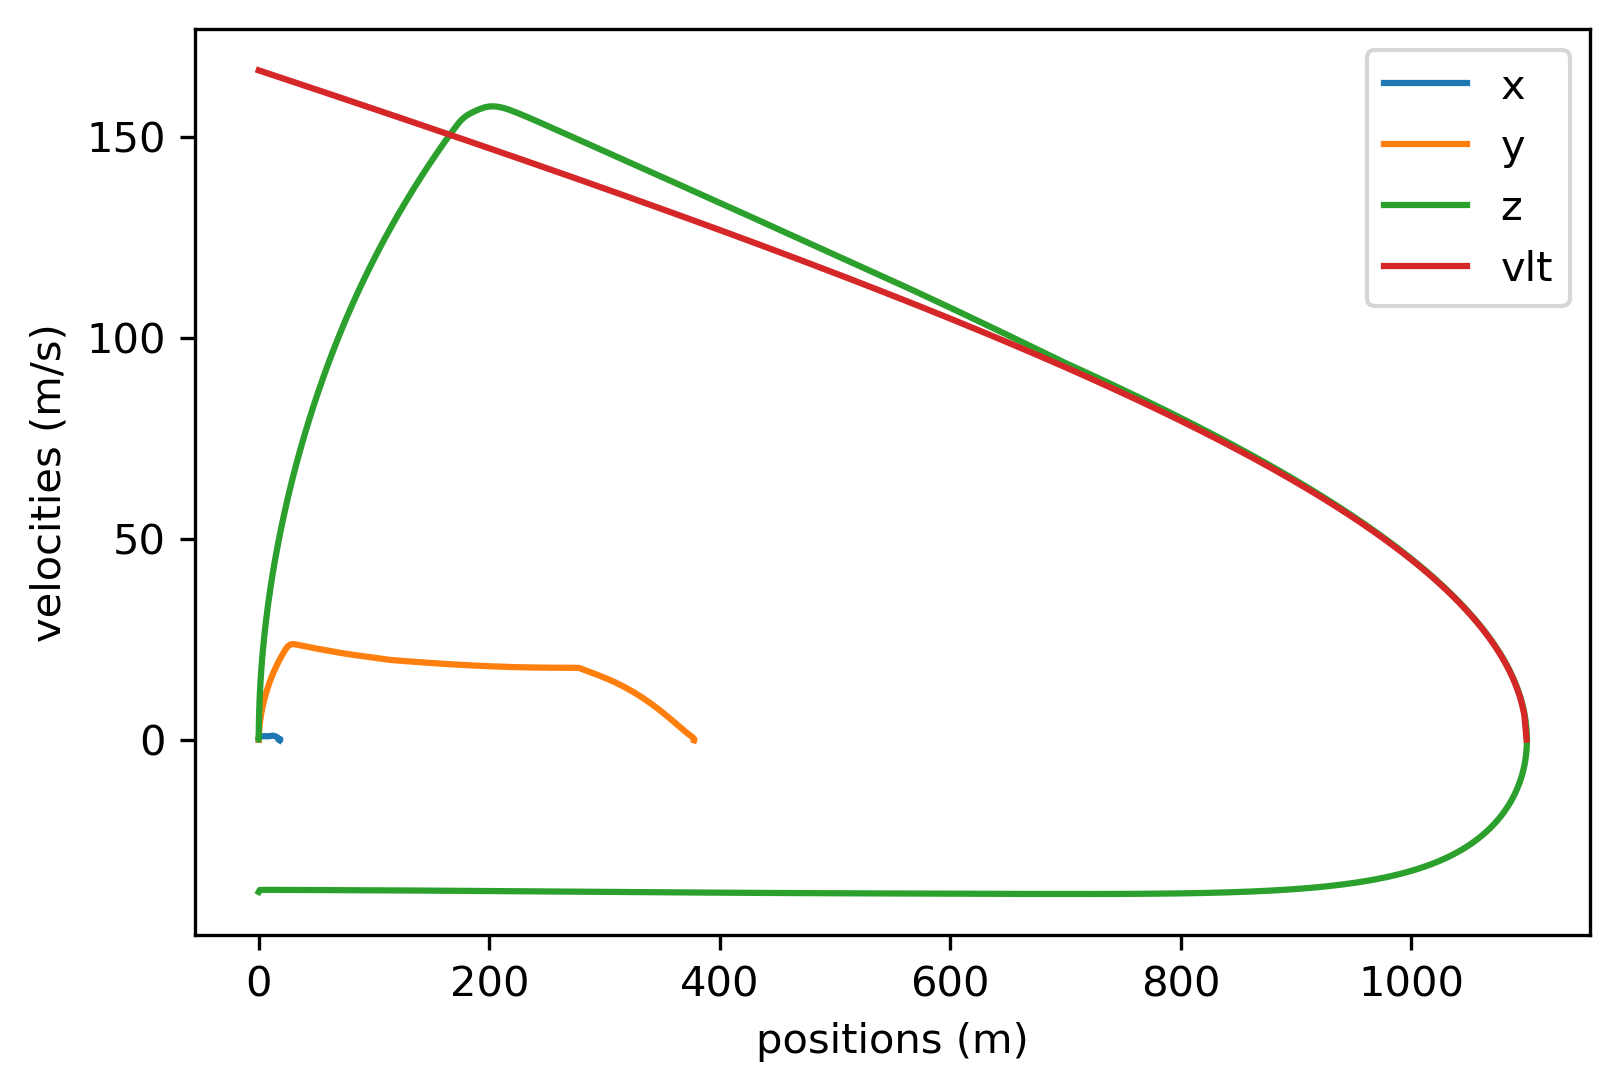

In [147]:
plt.figure(dpi=300)
plt.plot(positions,velocities);
plt.plot(velocityLookupTable[0],velocityLookupTable[1])
plt.xlabel('positions (m)')
plt.ylabel('velocities (m/s)')
plt.legend(['x','y','z','vlt']);

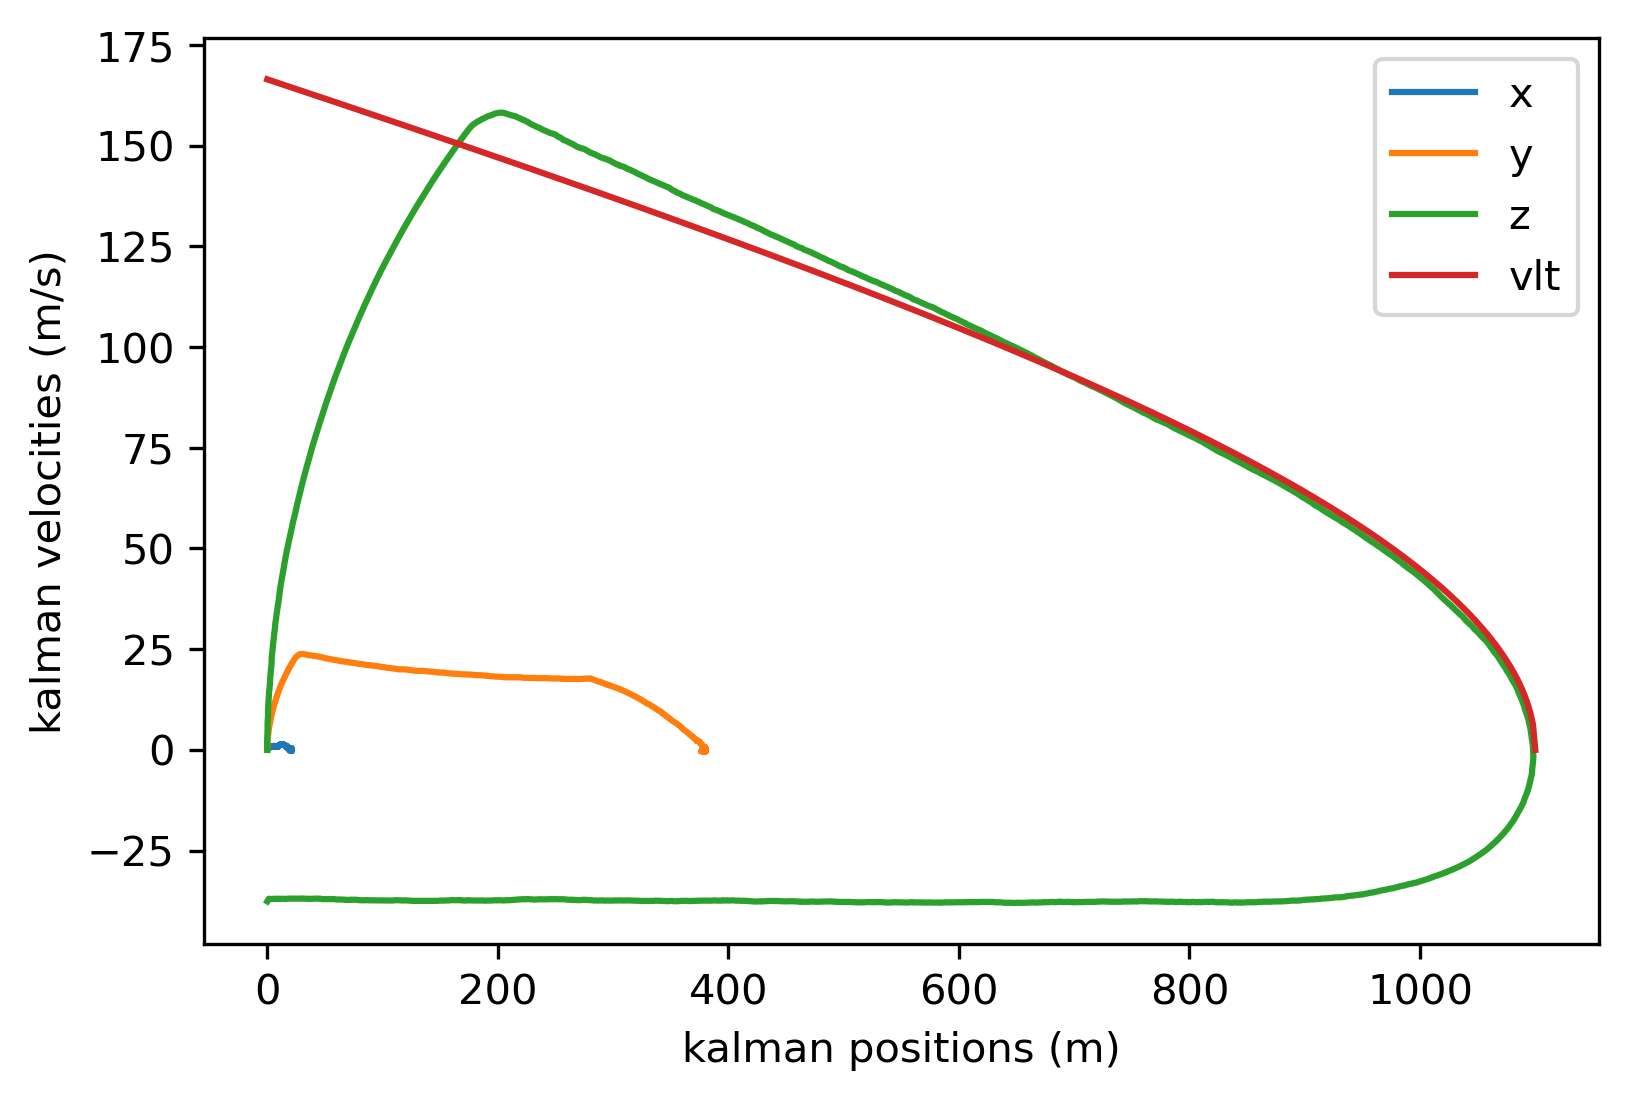

In [148]:
plt.figure(dpi=300)
plt.plot(stateVectors[:,0:3],stateVectors[:,3:6]);
plt.plot(velocityLookupTable[0],velocityLookupTable[1])
plt.xlabel('kalman positions (m)')
plt.ylabel('kalman velocities (m/s)')
plt.legend(['x','y','z','vlt']);

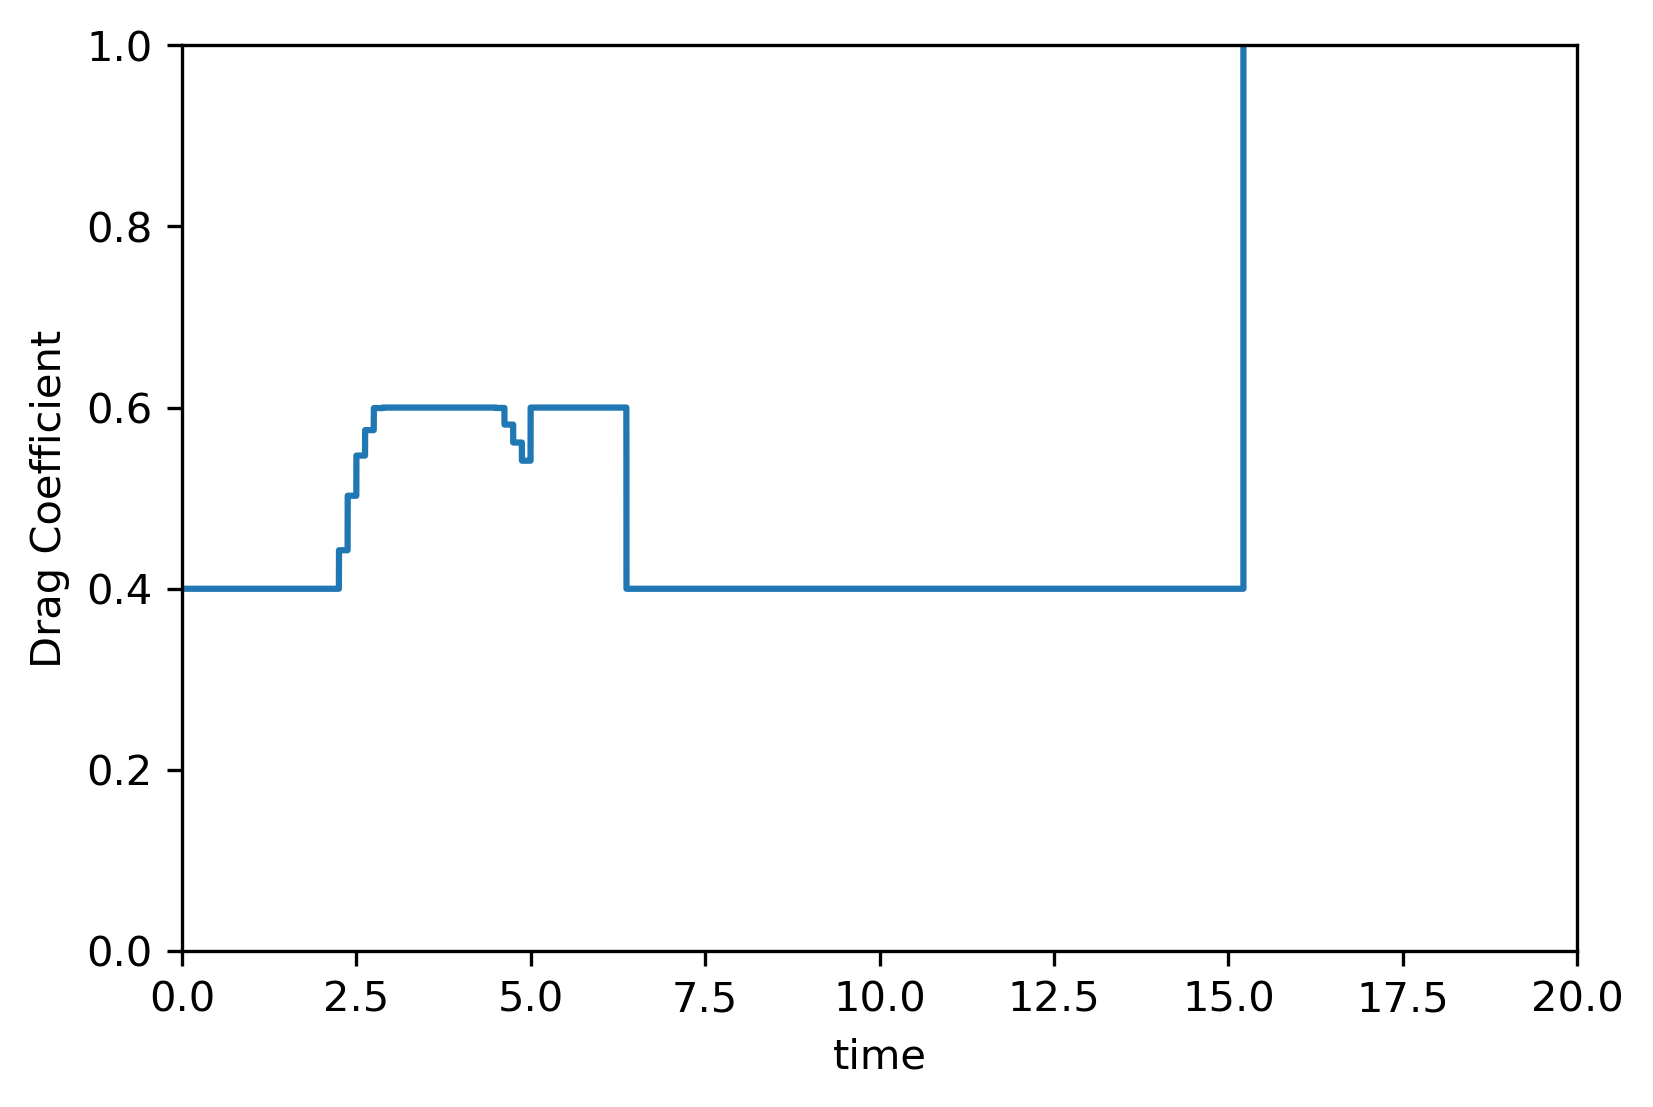

In [149]:
plt.figure(dpi=300)
plt.plot(time,dragCoefficient);
plt.ylim([0,1]);
plt.xlim([0,20]);
plt.xlabel('time')
plt.ylabel('Drag Coefficient');

In [150]:
np.max(positions[:,2])

1100.3043886571234

In [151]:
np.max(velocities[:,2])

157.51401778309895

In [152]:
positions[np.argmax(velocities[:,2]),2]

202.8973083143593